#Exemplo clássico MNIST

dataset com dígitos (0 a 9) manuscritos.

Conjunto de treinamento com 60000 exemplos e conjunto de teste com 10000 exemplos.

Alinhando Google: Drive - Colab.

In [ ]:
# a princípio somente é necessário executar uma vez por sessão
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/mnist

In [ ]:
%ls



---



In [ ]:
# importando módulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.autograd.grad_mode import no_grad

In [ ]:
# se quiser ignorar as msgs de advertência
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# lendo arquivos de dados
train_data = pd.read_csv('mnist_train.csv')
test_data = pd.read_csv('mnist_test.csv')

In [ ]:
# visualizando os dados de um exemplo (1 linha no t_data)
index = 30   # qualquer imagem dentre as 60000 de treino
image = train_data.iloc[index, 1:].values.astype(np.uint8).reshape((28, 28, 1))
label = train_data.iloc[index, 0]
print('Dígito (label): ',label)
plt.imshow(image.reshape(28,28),cmap='binary')

In [ ]:
# preparando para entrada da RNA (tensores)
X_train = torch.tensor(train_data.iloc[:,1:].values, dtype=torch.float32)
X_test = torch.tensor(test_data.iloc[:,1:].values, dtype=torch.float32)
qTrain = X_train.shape[0]
qTest = X_test.shape[0]
X_train.shape, X_test.shape, qTrain, qTest

In [ ]:
# separando as saídas (classes)
y_train = torch.tensor(pd.get_dummies(train_data['label']).values, dtype=torch.float32)
y_test = torch.tensor(pd.get_dummies(test_data['label']).values, dtype=torch.float32)
y_train.shape, y_test.shape

In [ ]:
# se quiser checar/visualizar tensor de entrada
X_train[0]



---



##Função **softmax**

Função que normaliza as unidades da camada de saída em uma distribuição Normal (de probabilidade).

Particularmente, no caso da rede neural usada aqui no problema de reconhecimento (MNIST), a função retorna a probabilidade de uma dada entrada (imagem) ser cada unidade de saída da RNA - ou seja, a probabilidade de ser cada um dos dígitos (0, 1, 2, 3, 4, 5, 6, 7, 8 ou 9).

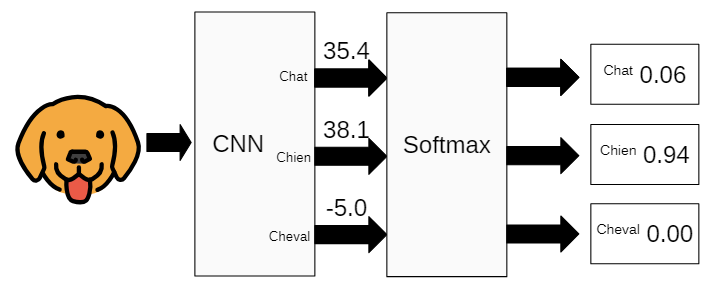https://upload.wikimedia.org/wikipedia/commons/4/4b/Softmax.svg



---



In [ ]:
# criando o modelo - nn.Sequencial(...)

torch.manual_seed(45)

dim_entrada = 784 # 28*28
dim_escondida = 20
dim_saida = 10

modelRNA = torch.nn.Sequential(
    nn.Linear(dim_entrada, dim_escondida),
    nn.ReLU(),
    nn.Linear(dim_escondida, dim_saida),
    nn.Softmax()
)

print(modelRNA)



---



##Função Custo (Loss) Cross Entropy

Cross Entropy (Entropia cruzada) é uma medida da diferença entre duas distribuições de probabilidade.


```
def cross_entropy(p, q):
 return -sum([p[i]*log2(q[i]) for i in range(len(p))])
```


def cross_entropy(p, q):
   return -sum([p[i]*log2(q[i]) for i in range(len(p))])

- adequada para classificação multivariável.



---



In [ ]:
# escolha da função custo / loss
fn_loss = nn.CrossEntropyLoss() # MSELoss é mais apropriada para regressão (ReLU)
                                # BCELoss baseada na entropia e usada para classificação binária
                                # CrossEntropyLoss é mais apropriada para classificação em geral



---



##Otimizadores comumente usados em Pytorch

-    **torch.optim.SGD( )**: Gradiente Descendente Estocástico
-    **torch.optim.RMSprop( )**: O algoritmo RMSprop divide o gradiente obtido por uma média móvel exponencial do gradiente ao quadrado.
-    **torch.optim.Adam( )**: O algortimo Adam (Estimação Adaptativa do Momento) é uma combinação do (GD com momento) com o RMSProp.





---



In [ ]:
# escolha do algoritmo de aprendizagem
optimizer = optim.SGD(modelRNA.parameters(), lr=0.1)

In [ ]:
# entendendo a saída do modelo
ind_ex = 2
print('Esperado:',test_data.iloc[ind_ex,0])
ax1=plt.subplot(121)
image = train_data.iloc[ind_ex, 1:].values.astype(np.uint8).reshape((28, 28, 1))
label = train_data.iloc[ind_ex, 0]
ax1.imshow(image.reshape(28,28),cmap='binary')
ax2=plt.subplot(122)
ax2.bar([0,1,2,3,4,5,6,7,8,9],modelRNA(X_test)[ind_ex].detach())#,torch.max(modelRNA(X_test),dim=1)[1][0:10]

In [ ]:
# calculando precisão do modelo antes do treinamento
y_pred_ind = torch.max(modelRNA(X_test),dim=1)[1]
y_test_ind = torch.max(y_test,dim=1)[1]
#print(y_pred)
accuracy = (y_pred_ind == y_test_ind).sum()/qTest
print(f"Precisão antes treinamento {accuracy:.4f}")

##Dataloader

O Dataloader é uma função que, a princípio, pode pegar qualquer coleção em Python e converte-la em um iterador em *batches* específicos.

Além disso, ela possibilita que apliquemos transformações nos dados durante a iteração - veremos com mais detalhes quando implementarmos o reconhecimento de imagens com as redes profundas clássicas.

In [ ]:
# dataloader
batch = 1000
trainDataset = DataLoader(list(zip(X_train,y_train)), batch_size=batch, shuffle=True)
testDataset = DataLoader(list(zip(X_test,y_test)), batch_size=batch, shuffle=False)

In [ ]:
# listas para registro do treinamento
trainLoss = []
testLoss = []
trainPredictOK = []
testPredictOK = []

n_epocas = 200

In [ ]:
# treinamento

for epoca in range(n_epocas):
  trainOK = 0
  testOK = 0

  for (X_train, y_train) in trainDataset:
    y_pred = modelRNA(X_train)
    loss = fn_loss(y_pred, y_train)

    predicted = torch.max(y_pred.data,1)[1]
    batchOK = (predicted == torch.max(y_train,1)[1]).sum()
    trainOK = trainOK + batchOK

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  trainLoss.append(loss.item())
  trainPredictOK.append(trainOK/qTrain)

  with torch.no_grad():
    for (X_test, y_test) in testDataset:
      y_pred = modelRNA(X_test)
      predicted2 = torch.max(y_pred.data, 1)[1]
      batchOK = (predicted2 == torch.max(y_test,1)[1]).sum()
      testOK = testOK + batchOK

    loss2 = fn_loss(y_pred, y_test)
    testLoss.append(loss2.item())
    testPredictOK.append(testOK/qTest)

  if (epoca == 0):
    print('Época\tTrainLoss\tTestLoss\tAccurTrain\tAccurTest')
    print(f'{epoca} \t {trainLoss[-1]:.4f}\t\t {testLoss[-1]:.4f}\t\t{trainPredictOK[-1]:.4f}\t\t{testPredictOK[-1]:.4f}')
  elif (epoca%10 == 0):
    print(f'{epoca} \t {trainLoss[-1]:.4f}\t\t {testLoss[-1]:.4f}\t\t{trainPredictOK[-1]:.4f}\t\t{testPredictOK[-1]:.4f}')



In [ ]:
plt.plot(testPredictOK,'red', label='Teste')
plt.plot(trainPredictOK, label='Treino')
plt.grid()
plt.legend()

In [ ]:
plt.plot(testLoss,'red',label='Teste')
plt.plot(trainLoss,label='Treino')
plt.grid()
plt.legend()

##Salvando modelos


A função **torch.save(model.state_dict( ), PATH)** salva o modelo e todos seus parâmetros.

.

A função **torch.load(PATH)** lê o modelo e seus parâmetros salvo no PATH e retorna o objeto modelo.




In [ ]:
torch.save(modelRNA,'modelo01.mod')

In [ ]:
%ls

In [ ]:
modelo = torch.load('modelo01.mod')
modelo.eval(), modelo.state_dict()

Vídeo didático que ajuda a explicar o funcionamento de uma RNA multicamada usando o reconhecimento de dígitos (MNIST) como exemplo.

https://www.youtube.com/watch?v=aircAruvnKk



---



##Atividade complementar

Faça testes com valores diferentes dos hiperparâmetros do aprendizado
(taxa de aprendizado, quantidade épocas de treinamento, otimizador, etc.)

 e das caracterísitcas das redes multicamadas (quantidade de camadas escondidas, quantidade neurônios por camada, tipos de função de ativação, etc.),
 de modo a obter:

 (1) o modelo (rna) com o melhor desempenho (precisão nos testes) possível;

 e (2) o modelo com o melhor custo benefício - ou seja,  melhor relação precisão / tempo de treinamento possível.

 * *preferencialmente, apresente seus resultados usando gráficos ou tabelas.*